- Ex1: Dùng Numpy implement thuật toán dbscan, test thử với dữ liệu.
- Ex2: Ý nghĩa tham số radius, min sample trong thuật toán dbscan? Nếu chỉ số lớn, nhỏ ảnh hưởng thế nào tới thuật toán?
- Ex3: Biến đổi lại và so sánh ba thuật toán: kmean, GMM, dbscan. Khi nào nên sử dụng thuật toán nào? cho ví dụ?

# Ex1:

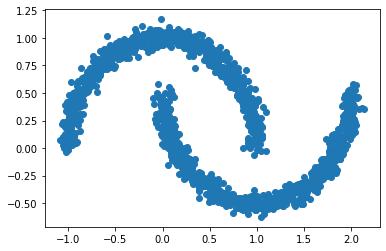

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
#colors = ['royalblue','red','deeppink', 'maroon', 'mediumorchid', 'tan', 'forestgreen', 'olive', 'goldenrod', 'lightcyan', 'navy']
#vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
X, y = make_moons(n_samples=1500, noise=0.05)
plt.scatter(X[:,0], X[:,1])

In [ ]:
def check_core_point(eps,minPts, df, index):
    #get points from given index
    x, y = df.iloc[index]['X']  ,  df.iloc[index]['Y']
    
    #check available points within radius
    temp =  df[((np.abs(x - df['X']) <= eps) & (np.abs(y - df['Y']) <= eps)) & (df.index != index)]
    
    #check how many points are present within radius
    if len(temp) >= minPts:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , True, False, False)
    
    elif (len(temp) < minPts) and len(temp) > 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, True, False)
    
    elif len(temp) == 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, False, True)
        
def cluster_with_stack(eps, minPts, df):
    
    #initiating cluster number
    C = 1
    #initiating stacks to maintain
    current_stack = set()
    unvisited = list(df.index)
    clusters = []
    
    
    while (len(unvisited) != 0): #run until all points have been visited

        #identifier for first point of a cluster
        first_point = True
        
        #choose a random unvisited point
        current_stack.add(random.choice(unvisited))
        
        while len(current_stack) != 0: #run until a cluster is complete
            
            #pop current point from stack
            curr_idx = current_stack.pop()
            
            #check if point is core, neighbour or border
            neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx)
            
            #dealing with an edge case
            if (isborder & first_point):
                #for first border point, we label it aand its neighbours as noise 
                clusters.append((curr_idx, 0))
                clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
                
                #label as visited
                unvisited.remove(curr_idx)
                unvisited = [e for e in unvisited if e not in neigh_indexes]
    
                continue
                
            unvisited.remove(curr_idx) #remove point from unvisited list
            
            
            neigh_indexes = set(neigh_indexes) & set(unvisited) #look at only unvisited points
            
            if iscore: #if current point is a core
                first_point = False
                
                clusters.append((curr_idx,C)) #assign to a cluster
                current_stack.update(neigh_indexes) #add neighbours to a stack

            elif isborder: #if current point is a border point
                clusters.append((curr_idx,C))
                
                continue

            elif isnoise: #if current point is noise
                clusters.append((curr_idx, 0))
                
                continue
                
        if not first_point:
            #increment cluster number
            C+=1
        
    return clusters

Text(0, 0.5, 'Y')

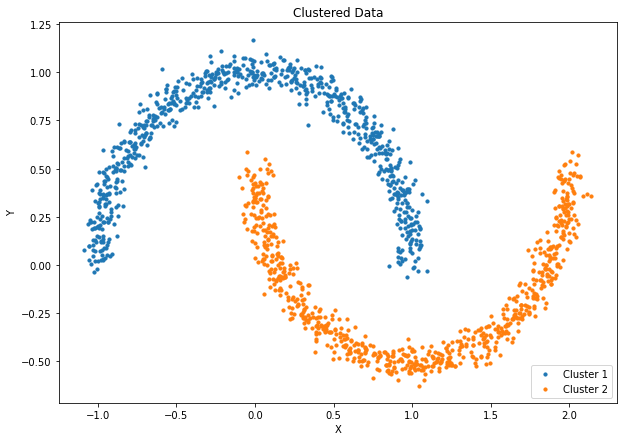

In [ ]:
eps = 0.1
minPts = 3
data = pd.DataFrame(X, columns = ["X", "Y"] )
clustered = cluster_with_stack(eps, minPts, data)

idx , cluster = list(zip(*clustered))
cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])

plt.figure(figsize=(10,7))
for clust in np.unique(cluster):
    plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], s=10, label=f"Cluster{clust}")

plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
plt.title('Clustered Data')
plt.xlabel('X')
plt.ylabel('Y')

#Ex2

**minPts:** Là một ngưỡng số điểm dữ liệu tối thiểu được nhóm lại với nhau nhằm xác định một vùng lân cận epsilon có mật độ cao. Số lượng minPts không bao gồm điểm ở tâm.
* MinPts = 1: giá trị  không có ý nghĩa, vì khi đó mọi điểm bản thân nó đều là một cụm. 
* MinPts = 2: kết quả sẽ giống như phân cụm phân cấp (hierarchical clustering) với single linkage với biểu đồ dendrogram được cắt ở độ cao  epsilon. 

=> Do đó,  phải được chọn ít nhất là 3. 

**epsilon:**  Một giá trị khoảng cách được sử dụng để xác định vùng lân cận epsilon của bất kỳ điểm dữ liệu nào.
* Nếu ϵ được chọn quá nhỏ, một phần lớn dữ liệu sẽ không được phân cụm và được xem là nhiễu
* Nếu ϵ được chọn quá cao, các cụm sẽ hợp nhất và phần lớn các điểm sẽ nằm trong cùng một cụm.

\

## Ex3

**Ưu và nhược điểm của K-means**

NHƯỢC:
- Chúng ta cần phải xác định trước số cụm cho thuật toán
-Vị trí tâm của cụm sẽ bị phụ thuộc vào điểm khởi tạo ban đầu của chúng: Những vị trí khởi tạo khác nhau có thể dẫn tới cách phân cụm khác nhau, mặc dù thuật toán có cùng thiết lập số cụm.
-Đối với những bộ dữ liệu có hình dạng phức tạp hoặc mất cân bằng thì thuật toán không hội tụ về qui luật phân chia tổng quát. 
-Thuật toán rất nhạy cảm với outliers: Khi xuất hiện outliers thì thường khiến cho tâm cụm bị chệch và do đó dự báo cụm không còn chuẩn xác. 
-Thuật toán nhạy cảm với độ lớn đơn vị của biến.Chính vì thế chúng ta cần phải chuẩn hoá biến để loại bỏ sự khác biệt đơn vị trước khi đưa vào huấn luyện mô hình.
-Thuật toán k-Means yêu cầu phải tính khoảng cách từ một điểm tới toàn bộ các tâm cụm để tìm ra tâm cụm gần nhất. Như vậy chúng ta cần phải load toàn bộ dữ liệu lên RAM, đối với những bộ dữ liệu kích thước lớn thì sẽ vượt quá khả năng lưu trữ của RAM. 

=> Trường hợp sử dụng: kích thước cụm đồng đều, hình học phẳng, không quá nhiều cụm.

**Ưu và nhược điểm của GMM**

Ưu:

+ xử lý nhiều hình dạng hơn, chủ yếu là các cụm tạo thành hình elip (K-Means chỉ thực sự tốt ở các cụm có dạng gần giống hình cầu)

+ soft assignment: trong k-means 1 điểm chỉ thuộc 1 cluster do k-means là hard assigment. Tuy nhiên, ở trong GMM, 1 điểm có thể thuộc vào nhiều cluster với mức độ khác nhau. Điều này hữu ích trong một số task như một bài báo có thể thuộc nhiều chủ đề,..

Nhược:

+ không xác định chính xác được một số cụm có hình dạng khác

=> Trường hợp sử dụng: ước tính mật độ và hình học phẳng.

**Ưu và nhược điểm của DBScan**

Ưu: 

+ tự động loại bỏ được các điểm dữ liệu nhiễu
+ hoạt động tốt đối với những dữ liệu có hình dạng phân phối đặc thù 
+ có tốc độ tính toán nhanh.

Nhược:

+ không hiệu quả đối với những dữ liệu có phân phối đều khắp nơi.
+ Nhạy cảm với các thông số eps và minPts.

=> Trường hợp sử dụng: kích thước cụm không đồng đều và hình học không phẳng
